In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ler.rates import LeR
from ler.utils import get_param_from_json

### Table for GRB rates and associate GW rates

| Event         | Unlensed  | Lensed    | Lensed:Unlensed |
| ---           | ---       | ---       | ---             |
| GRB           | 11543.22  | 10.60     | 1:1088.98       |
| GW(snr>8)     | 2.39      | 4.35e-3   | 1:549.42        |
| GW(snr>8):GRB | 1:4819.28 | 1:2439.02 | -               |
| GW(snr>6)     | 4.93      | 1.03e-2   | 1:478.64        |
| GW(snr>6):GRB | 1:2339.18 | 1:1030.93 | -               |

#

| Event            | Unlensed | Lensed  | Lensed:Unlensed |
| ---              | ---      | ---     | ---             |
| GW(snr>8)        | 21.07    | 5.26e-2 | 1:400.57        |
| GRB (associated) | 1.91     | 3.99e-3 | 1:478.69        |
| GRB:GW(snr>8)    | 1:11.01  | 1:13.20 | -               |

In [2]:
# initialize the LeR object
ler = LeR(verbose=False)

In [3]:
ler.batch_size = 50000
ler.lensed_cbc_statistics(
    size=100000,
    save_batch=False,
    resume=True,
    output_jsonfile="lensed_params_dt_hyperspace.json",
);

lensed params will be store in ./ler_data/lensed_params_dt_hyperspace.json
chosen batch size = 50000 with total size = 100000
There will be 2 batche(s)
Batch no. 1
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 50000/50000 [00:14<00:00, 3339.29it/s]


Invalid sample found. Resampling 1 lensed events...
solving lens equations...


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.17s/it]


calculating snrs...
Batch no. 2
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 50000/50000 [00:14<00:00, 3382.87it/s]


Invalid sample found. Resampling 1 lensed events...
solving lens equations...


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]


calculating snrs...
saving all lensed_params in ./ler_data/lensed_params_dt_hyperspace.json 


In [8]:
# load the data
data = get_param_from_json("ler_data/lensed_params_dt_hyperspace.json")

dt = data['effective_geocent_time']
snr = data['optimal_snr_net']

In [9]:
# select only 4 image events
# select non-nan values each row
mask = ~np.isnan(dt)
idx = np.where(mask.sum(axis=1) == 4)[0]
len(idx)

11102

In [10]:
dt12 = dt[idx, 1]-dt[idx, 0]
dt13 = dt[idx, 2]-dt[idx, 0]
dt14 = dt[idx, 3]-dt[idx, 0]
dt23 = dt[idx, 2]-dt[idx, 1]
dt24 = dt[idx, 3]-dt[idx, 1]
dt34 = dt[idx, 3]-dt[idx, 2]

# convert to days
# use log10 scale
log10_dt12 = np.log10(dt12/86400)
log10_dt13 = np.log10(dt13/86400)
log10_dt14 = np.log10(dt14/86400)
log10_dt23 = np.log10(dt23/86400)
log10_dt24 = np.log10(dt24/86400)
log10_dt34 = np.log10(dt34/86400)

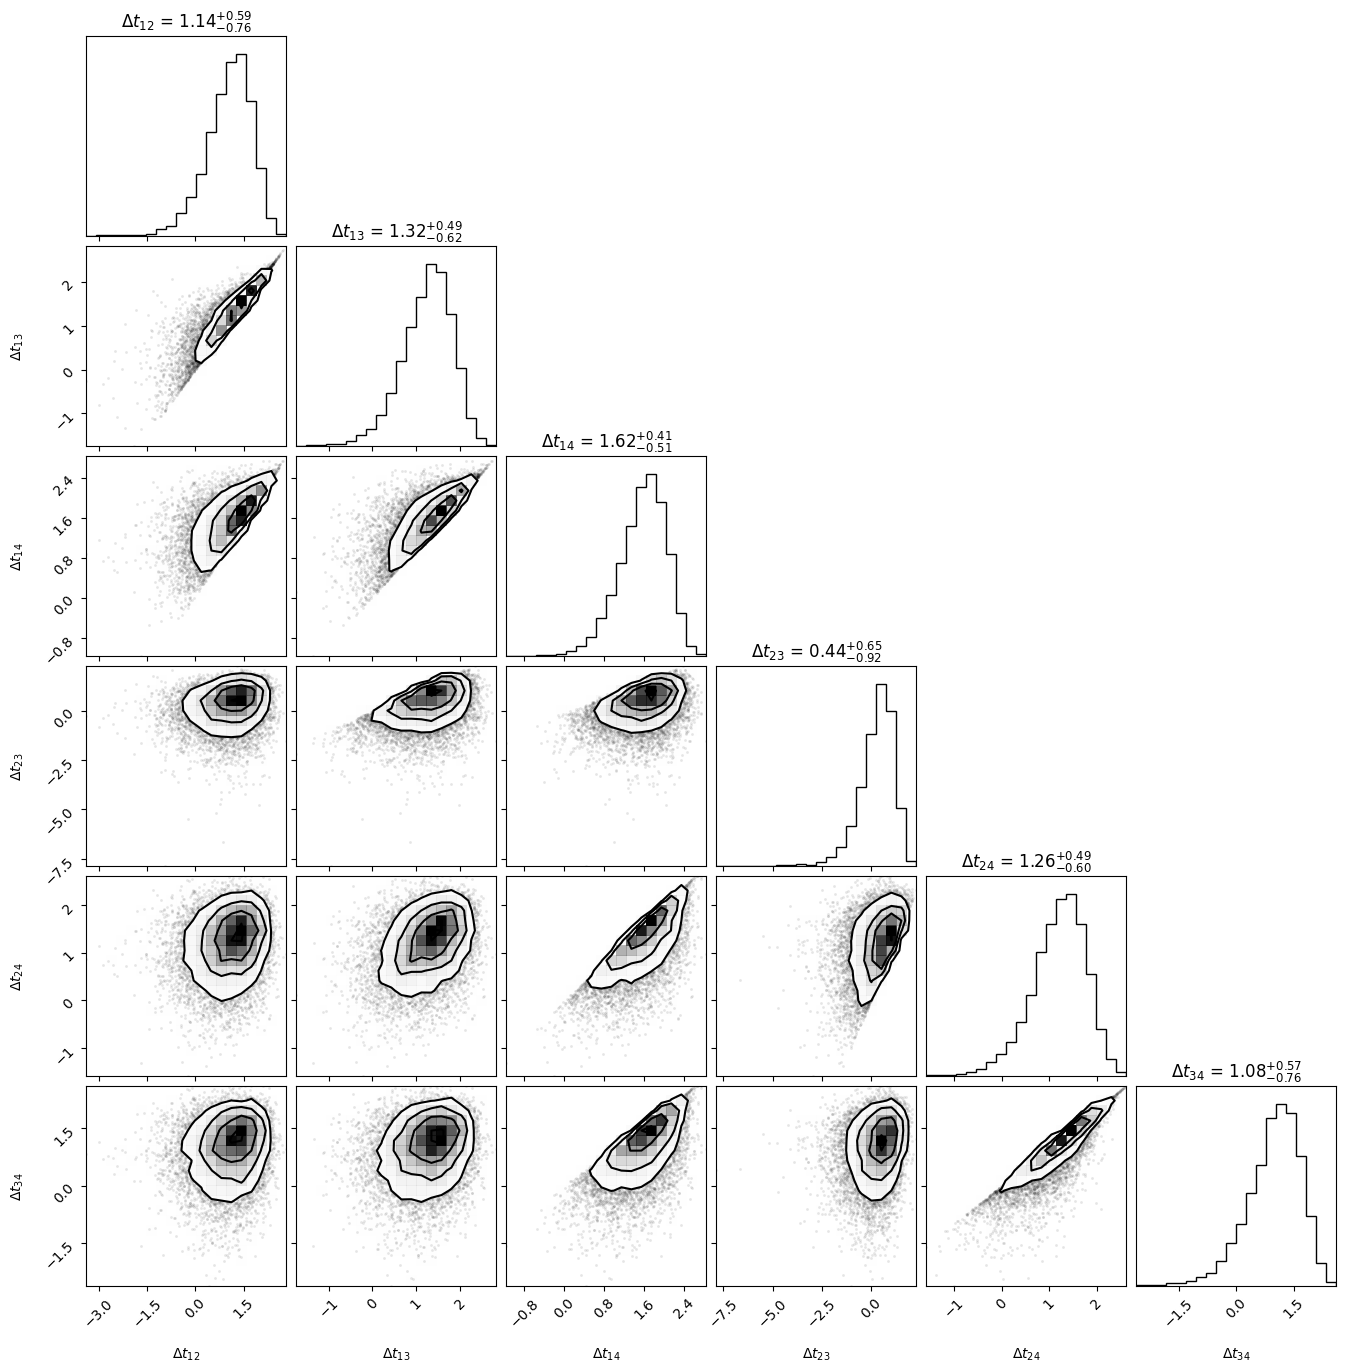

In [11]:
# plot corner plot
import corner
samples = np.vstack([log10_dt12, log10_dt13, log10_dt14, log10_dt23, log10_dt24, log10_dt34]).T
fig = corner.corner(samples, labels=[r"$\Delta t_{12}$", r"$\Delta t_{13}$", r"$\Delta t_{14}$", r"$\Delta t_{23}$", r"$\Delta t_{24}$", r"$\Delta t_{34}$"], show_titles=True)
plt.show()

## Using dimensionless time-delay difference

In [28]:
# find time delay scaling
zl = data['zl'][idx]    # lens redshift
zs = data['zs'][idx]    # source redshift
# convert arcsec to radian
thetaE = data['theta_E'][idx]    # Einstein radius arcsec
thetaE = thetaE * np.pi/648000
# convert to angular diameter distance
Dl = ler.angular_diameter_distance(zl)* 3.086e22
Ds = ler.angular_diameter_distance(zs)* 3.086e22
Dls = ler.angular_diameter_distance_z1z2(zl, zs)* 3.086e22

In [29]:
c = 299792458
scaling_factor = (1+zl)/c * Ds/(Dl*Dls) * thetaE**2

In [30]:
# dimensionless time delay
dtau12 = dt12 / scaling_factor
dtau13 = dt13 / scaling_factor
dtau14 = dt14 / scaling_factor
dtau23 = dt23 / scaling_factor
dtau24 = dt24 / scaling_factor
dtau34 = dt34 / scaling_factor

# convert to days
# use log10 scale
log10_dtau12 = np.log10(dtau12/86400)
log10_dtau13 = np.log10(dtau13/86400)
log10_dtau14 = np.log10(dtau14/86400)
log10_dtau23 = np.log10(dtau23/86400)
log10_dtau24 = np.log10(dtau24/86400)
log10_dtau34 = np.log10(dtau34/86400)

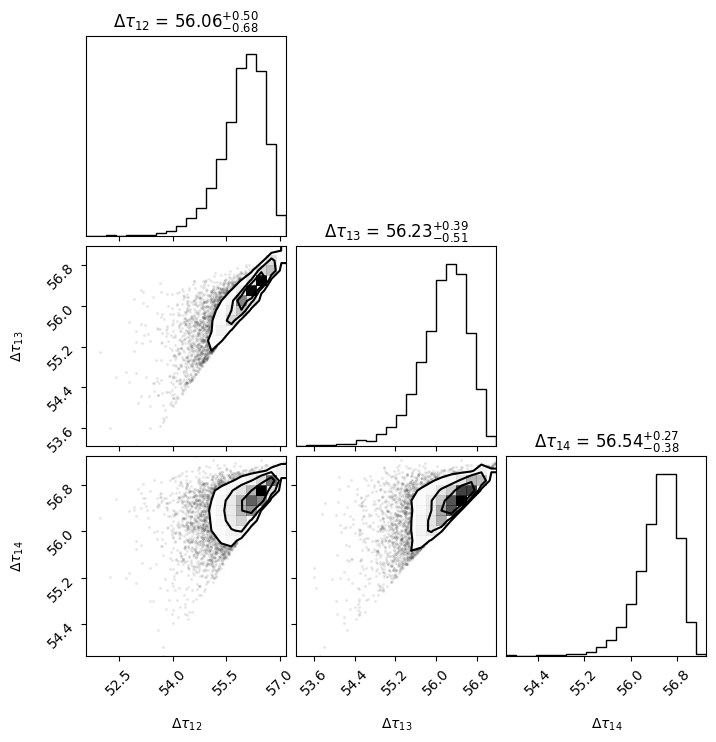

In [33]:
# plot corner plot
samples = np.vstack([log10_dtau12, log10_dtau13, log10_dtau14]).T
fig = corner.corner(samples, labels=[r"$\Delta \tau_{12}$", r"$\Delta \tau_{13}$", r"$\Delta \tau_{14}$"], show_titles=True)

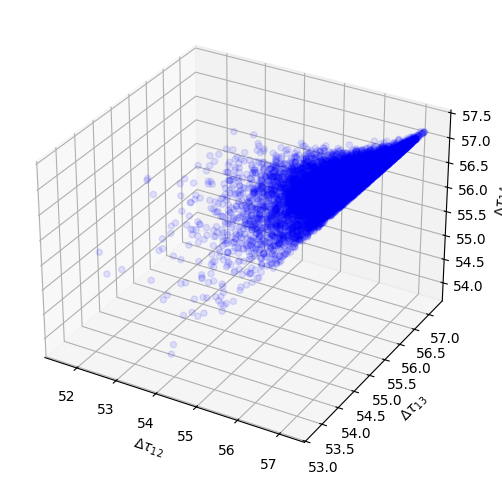

In [35]:
# 3D plot for log10_dtau12, log10_dtau13, log10_dtau14
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(log10_dtau12, log10_dtau13, log10_dtau14, c='b', marker='o', alpha=0.1)
ax.set_xlabel(r"$\Delta \tau_{12}$")
ax.set_ylabel(r"$\Delta \tau_{13}$")
ax.set_zlabel(r"$\Delta \tau_{14}$")
plt.show()